# <center>Machine learning from scratch - Day II</center>
## <center>18 July, 2019 @ Bayer AG R&D, Berlin, Germany</center>
### <center>Marco Chierici & Margherita Francescatto</center>
#### <center>_FBK/MPBA_</center>

Recap. We are using a subset of the SEQC neuroblastoma data set [Zhang et al, Genome Biology, 2015] consisting of 272 samples (136 training, 136 test). The data was preprocessed a bit to facilitate the progress of the tutorial.

We start by loading the modules we need to process the data.

In [1]:
import numpy as np
import pylab as plt ## for plotting
import pandas as pd ## for reading text files and manipulating data frames
from sklearn import metrics
from sklearn import neighbors ## kNN classifier
%matplotlib inline
np.random.seed(42) ## set random seed just in case

# 1. Data loading

Define files to read:

In [2]:
##  for convenience, define the data directory as a variable
DATA_DIR = "data/"
DATA = DATA_DIR + "MAV-G_272.txt"
LABS = DATA_DIR + "labels.txt"
data = pd.read_csv(DATA, sep = "\t")

# We drop the first column from the train and test expression sets, since it's just the sample IDs...
data = data.drop('sampleID', axis=1)
# ...and store the data into Numpy arrays.
X = data.values
# Now we read in the files containing labels and select the column with the CLASS target
labs = pd.read_csv(LABS, sep = "\t")
class_lab = labs[['CLASS']]
y = class_lab.values.ravel()

In [3]:
# following our consolidated practice, print the shape of the data as a sanity check:
X.shape

(272, 52229)

In [4]:
y.shape

(272,)

# 2. Data partitioning

### Hold-out strategy

The idea behind data partitioning is to split your original data set into a **train** portion (for developing your machine learning model) and a **test** portion (for evaluating the performance of the trained model).

The simplest and most straightforward way to partition your data set is to randomly split it in two groups (*hold-out strategy*).

You achieve this using scikit-learn's function `train_test_split`, in the `model_selection` submodule.

For example, let's split the data (X) into 80% train and 20% test (note the argument `test_size=0.2`). Use a random_state of your choice:

In [6]:
from sklearn.model_selection import train_test_split
x_tr, x_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.2, random_state=78)



---

What is the random_state?

Whenever randomness is involved in a computer program, we need to rely on some sort of workaround because computers follow their instructions blindly and they are therefore completely predictable.

One approach relies on *Pseudo-Random Number Generators* (PRNGs). 

PNRGs are algorithms that use mathematical formulas or precalculated tables to produce sequences of numbers that appear random. 

PNRGs are initialized by a *seed* (an integer), so that *the same seed yields the same sequence of pseudo-random numbers*. This is useful for reproduciblity.


---



# 3. Data preprocessing

In [7]:
from sklearn import preprocessing
## first you need to create a "scaler" object
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
## then you actually scale data by fitting the scaler object on the data
scaler.fit(x_tr)
x_tr = scaler.transform(x_tr)
x_ts = scaler.transform(x_ts)

# 4. Supervised Learning

Scikit-learn provides you access to several models via a very convenient _fit_ and _predict_ interface.

## 4.1 k-NN classifier

For example, let's fit a k-NN model on the whole training data and then use it to predict the labels of the test data.

In [9]:
knn = neighbors.KNeighborsClassifier(n_neighbors=10)

In [10]:
knn.fit(x_tr, y_tr)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [11]:
y_pred_knn = knn.predict(x_ts) # predict labels on test data

_In general, a classifier has **parameters** that need to be tuned. Default choices are not good in all situations._

_For example, in k-NN the main parameter is the **number of neighbors** used in the nearest neighbors algorithm._

To evaluate the predictions we need some kind of metrics. 

## Performance assessment: Confusion matrix

In this example, the first row is class 0, so the confusion matrix will look like:

|      |  |  Predicted  |    |
|------|-----------|----|----|
|      |           | 0 | 1  |
| True | 0        | TN | FP |
|      | 1         | FN | TP |


In [12]:
conf = metrics.confusion_matrix(y_ts, y_pred_knn)
conf

array([[15,  7],
       [ 0, 33]])

The total number of class 0 test samples (AN = All Negatives) should be equal to the sum of the first row of the confusion matrix, i.e., TN + FP:

In [13]:
np.sum(y_ts == 0) # total number of "class 0" samples in the test set

22

Similarly for class 1, i.e., AP = All Positives = TP + FN:

In [14]:
np.sum(y_ts==1) # total number of "class 1" samples in the test set

33

**Exercise**

* Compute the Accuracy, remembering/using the formula ACC = (TN + TP) / (TN + TP + FN + FP)
* Compute the Sensitivity (also known as "Recall"), using the formula SENS = TP / (TP + FN)

Computing metrics by hand is good, but what about a quicker option?

As seen in the lectures, Scikit Learn offers a handy broad range of functions to evaluate your classifier through its submodule `metrics`.

* Compute the accuracy and sensitivity using the scikit-learn built-in functions `metrics.accuracy_score` and `metrics.recall_score`, taking as input the predicted labels and the true labels
* Do you know of another metric that better summarizes the confusion matrix?

In [16]:
tn = conf[0, 0]
fp = conf[0, 1]
fn = conf[1, 0]
tp = conf[1, 1]

acc = (tn + tp) / (tn + tp + fn + fp)
sens = tp / (tp + fn)

print("ACC = ", acc)
print("SENS = ", sens)

ACC =  0.8727272727272727
SENS =  1.0


In [20]:
print("ACC = ", metrics.accuracy_score(y_ts, y_pred_knn))
print("SENS = ", metrics.recall_score(y_ts, y_pred_knn))

ACC =  0.8727272727272727
SENS =  1.0


Let's consider now the Matthews Correlation Coefficient (MCC):

![MCC formula](https://www.researchgate.net/profile/Pablo_Moscato/publication/223966631/figure/fig1/AS:305103086080001@1449753652505/Calculation-of-Matthews-Correlation-Coefficient-MCC-A-Contingency-matrix_W640.jpg)

*Q: Do you remember the main features of MCC?*

In scikit-learn it is computed by the `metrics.matthews_corrcoef` function.

If we get the MCC for our kNN predictions, we can observe that it is in line with our *a priori* knowledge of the dataset (from the article):

In [21]:
print(metrics.matthews_corrcoef(y_ts, y_pred_knn))

0.75


So far we focused on the k-NN classifiers. In the previous lecture, however, we explored theoretical aspects related to two other broadly used classifiers: Support Vector Machines (SVMs) and Random Forests (RFs). In this part of tutorial, the first thing we want to do is assessing how these two alternative classification methods perform on our neuroblastoma dataset.

## 4.2 Support Vector Machines

We start with SVM. We first rescale the data, import the relevant model and create an instance of the SVM classifier. Use the same seed used previously.

In [25]:
# reminder: x_tr, x_ts were previously rescaled using the MinMaxScaler.
# Now we want to standardize the features, so we need to recreate the original arrays:
x_tr, x_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.2, random_state=78)

scaler = preprocessing.StandardScaler()
## then you actually scale data by fitting the scaler object on the data
scaler.fit(x_tr)
x_tr = scaler.transform(x_tr)
x_ts = scaler.transform(x_ts)

In [36]:
## import support vector classifier (SVC) and create an instance
from sklearn.svm import SVC
svc = SVC(kernel='linear')

Note that the specification _kernel = 'linear'_ implies that a linear kernel will be used. If you remember from the lecture, this means that a linear function is used to define the decision boundaries of the classifier. Alternatives include _‘poly’_ and _‘rbf’_ for polynomial or gaussian kernels respectively. Scikit-learn offers an alternative implementation of linear SVMs. You can find more details in Scikit User Guide. 

**Tip:** always start experimenting with the linear kernel, which is the simplest one; try more complex kernels later on (Occam's razor...)

As previously done with the k-NN classifier, we fit an SVM model on the training data:

In [38]:
svc.fit(x_tr, y_tr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Simple as that. Now we have a fitted SVM model that we can use to make predictions on new data.

Of course there are a few parameters that may require tuning: more on this later.

### Making predictions

In [39]:
y_pred_svm = svc.predict(x_ts)

We now have a set of predictions for each entry in the test set. Since we also have the actual labels for each record in the test set, we can use them to assess the performance of the SVM model.

Now we give a look at the classification metrics introduced in the first part of the tutorial.

In [40]:
print('MCC = ', metrics.matthews_corrcoef(y_ts, y_pred_svm))
print('ACC = ', metrics.accuracy_score(y_ts, y_pred_svm))
print('SENS = ', metrics.recall_score(y_ts, y_pred_svm))

MCC =  0.9279607271383369
ACC =  0.9636363636363636
SENS =  0.9393939393939394


## 4.3 Random Forest

Thanks to scikit-learn simple API, we can easily create a RandomForest instance and fit it to our training data:

In [51]:
from sklearn.ensemble import RandomForestClassifier as RFC
clf = RFC(n_estimators=500, random_state=42)
clf.fit(x_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### Making predictions

In [52]:
y_pred_rfc = clf.predict(x_ts)

Compute a few metrics using the actual test set labels:

In [53]:
print('MCC = ', metrics.matthews_corrcoef(y_ts, y_pred_rfc))
print('ACC = ', metrics.accuracy_score(y_ts, y_pred_rfc))
print('SENS = ', metrics.recall_score(y_ts, y_pred_rfc))

MCC =  0.894427190999916
ACC =  0.9454545454545454
SENS =  0.9090909090909091


How did you do? Note that (not surprisingly) there is an element of randomness in a "random forest". 

I'm getting an accuracy of about 94-98%, but "your mileage may vary": the precise number will be different each time you run the algorithm.

### Probabilities

Depending on the algorithm, some of the supervised models in scikit-learn can also provide the **probability** that a record belongs in each category. 

For random forest, we can obtain these probabilities by calling the `predict_proba` method on the fitted model. Because we have two categories, 0 (negative) and 1 (positive), scikit-learn will return two category probabilities (the sum across all categories will add up to 1).

Looking at the prediction probabilities may be useful to understand on which samples the classifier is "unsure" (i.e., the probabilities are around 0.5 for both classes).

In [54]:
prob_rfc = clf.predict_proba(x_ts)

In [56]:
print(prob_rfc)

[[0.044 0.956]
 [0.778 0.222]
 [0.504 0.496]
 [0.602 0.398]
 [0.054 0.946]
 [0.042 0.958]
 [0.064 0.936]
 [0.206 0.794]
 [0.044 0.956]
 [0.684 0.316]
 [0.954 0.046]
 [0.034 0.966]
 [0.836 0.164]
 [0.062 0.938]
 [0.656 0.344]
 [0.17  0.83 ]
 [0.152 0.848]
 [0.948 0.052]
 [0.618 0.382]
 [0.512 0.488]
 [0.95  0.05 ]
 [0.896 0.104]
 [0.868 0.132]
 [0.974 0.026]
 [0.07  0.93 ]
 [0.682 0.318]
 [0.172 0.828]
 [0.538 0.462]
 [0.028 0.972]
 [0.038 0.962]
 [0.506 0.494]
 [0.2   0.8  ]
 [0.042 0.958]
 [0.072 0.928]
 [0.624 0.376]
 [0.94  0.06 ]
 [0.528 0.472]
 [0.058 0.942]
 [0.028 0.972]
 [0.044 0.956]
 [0.004 0.996]
 [0.132 0.868]
 [0.956 0.044]
 [0.064 0.936]
 [0.11  0.89 ]
 [0.968 0.032]
 [0.144 0.856]
 [0.58  0.42 ]
 [0.036 0.964]
 [0.058 0.942]
 [0.022 0.978]
 [0.372 0.628]
 [0.948 0.052]
 [0.442 0.558]
 [0.812 0.188]]


## Trying different classifiers

scikit-learn makes it easy to try different classifiers. 

Neural networks, naive bayes, random forest, logistic regression, support vector machines, and other algorithms all have a very similar interface (of course the underlying mathematics can be dramatically different!) 

1. you create an instance of the model (in the variable, say, `clf`), optionally tuning the parameters; 
2. you fit the model on some training data (`clf.fit(x_tr, y_tr)`); 
3. you predict the labels of unseen test data (`clf.predict(x_ts)`). 


### Exercise: neural net!

To use a neural net, you only need to make a few changes to this workbook.

First, load the appropriate library

from sklearn.neural_network import MLPClassifier

Then, call a neural network classifier rather than a random forest model

clf = MLPClassifier()

Proceed as usual to fit and make predictions.

_Et voilà!_ In seconds you are making classification predictions using a neural net model rather than a random forest!

* Train a neural net and assess its performance on the test set;
* Compare the performance of the classifiers you just used;
* Given the performance metrics you assessed, can you say there is a "best" classification algorithm? Do you think this algorithm will perform better on a different task / data?

Hint: the effectiveness depends on a number of factors, mainly the **classifier parameters** and the **data**. Some data sets just match very well to a particular prediction algorithm.

**Exercise** 

* Compare the metrics of the different classifiers. What can you say about this classification task? Do the classifiers learn something?
* Which classifier has the best accuracy and MCC?
* Are you confident enough that such classifier is able to *generalize* beyond its training set?
* Do you know if there is a more robust way to assess the performance of the models?


# 5. Cross-validation

So far we fitted several models on our training data, then we predicted the labels on the test data, computing a set of metrics.

How can we know if our model is going to generalize well on new unseen data?

We need a more robust way to _estimate_ the model performance and its generalization capabilities.

We already used the **hold-out strategy**, with scikit's `train_test_split` function, to split our `X` data into one training/test partition.

Partitioning the dataset once is not enough. The partitions depend on the random seed used in the splitting function.

More robust strategies involve splitting the data in **multiple (complementary) subsets**.

One of such strategies is the **k-fold cross-validation**, introduced during the lecture:

![k-fold cv](https://www.researchgate.net/profile/B_Aksasse/publication/326866871/figure/fig2/AS:669601385947145@1536656819574/K-fold-cross-validation-In-addition-we-outline-an-overview-of-the-different-metrics-used_W640.jpg)

Example of a 5-fold cross-validation (CV) with scikit-learn:

In [57]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

A "stratified" 5-fold CV means that the folds are made by preserving the percentage of samples for each class.

_Recap:_ the same random_state will generate the same splits. This is useful for reproducibility.

To actually get the splitting indices and create the folds, we need to iterate over the `skf` object. Note that here I am using a Random Forest: feel free to experiment with other classifiers!

In [58]:
## get the number of splitting operations
N = skf.get_n_splits(X, y)

## reinitialize a classifier
clf = RFC(n_estimators=500)

## create empty lists to store the CV metrics
acc_list = []
mcc_list = []

## split data and iterate over the splits,
## computing classifier accuracy & MCC on each test partition
n_fold = 1
for (idx_tr, idx_ts) in skf.split(X, y):
    print("### Fold ", n_fold)
    X_train, Y_train = X[idx_tr], y[idx_tr]
    X_test, Y_test = X[idx_ts], y[idx_ts]
    print()
    clf.fit(X_train, Y_train)
    Y_test_pred = clf.predict(X_test)
    acc = metrics.accuracy_score(Y_test, Y_test_pred)
    mcc = metrics.matthews_corrcoef(Y_test, Y_test_pred)
    print("Accuracy on TEST set: ", acc)
    print("MCC on TEST set: ", mcc)
    print()
    ## append values to lists
    acc_list.append(acc)
    mcc_list.append(mcc)
    
    n_fold = n_fold + 1

### Fold  1

Accuracy on TEST set:  0.9285714285714286
MCC on TEST set:  0.8406827880512091

### Fold  2

Accuracy on TEST set:  0.8888888888888888
MCC on TEST set:  0.7470178808339961

### Fold  3

Accuracy on TEST set:  0.9814814814814815
MCC on TEST set:  0.9597148699373932

### Fold  4

Accuracy on TEST set:  0.9814814814814815
MCC on TEST set:  0.9586025865388215

### Fold  5

Accuracy on TEST set:  0.9629629629629629
MCC on TEST set:  0.9219544457292888



*Q: how are the computed metrics on the different folds?*

To get an estimate of the predictive performance of our model, we can average over the cross-validation metrics.

In [59]:
## note: we need to convert the lists to numpy arrays before computing the means
acc_avg = np.mean(np.array(acc_list))
mcc_avg = np.mean(np.array(mcc_list))

print("Average cross-validation accuracy:", acc_avg)
print("Average cross-validation MCC:", mcc_avg)

Average cross-validation accuracy: 0.9486772486772488
Average cross-validation MCC: 0.8855945142181417


### Remark

If you want to be cool and have an even better estimate of how the model can generalize on new data, you can repeat the cross-validation several times ("iterated cross-validation"). Each time you need using a different random_state for generating the splits.

# 6. Feature ranking

One type of insight you can gain from a machine learning model is the feature importance (or weight). Which genes are most likely to influence the classification of our neuroblastoma patients? Are some features pivotal, and others largely ignored?

Because a Random Forest model branches repeatedly on different features, the model becomes "aware" of which features are particularly influential in classifiying a patient. 

Scikit-learn allows us to read this information off of a trained Random Forest model through the `feature_importances_` attribute (mind the trailing underscore!).

In [60]:
# Retrain a random forest
rf = RFC(n_estimators=500)
rf.fit(x_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

For the sake of completeness make the predictions and check the classification performance.

In [61]:
y_pred_rfc = rf.predict(x_ts)
print('MCC = ', metrics.matthews_corrcoef(y_ts, y_pred_rfc))
print('ACC = ', metrics.accuracy_score(y_ts, y_pred_rfc))
print('SENS = ', metrics.recall_score(y_ts, y_pred_rfc))

MCC =  0.8878456665075479
ACC =  0.9454545454545454
SENS =  0.9393939393939394


Now extract the feature importances and display the first 10:

In [62]:
# get the importances
importances = rf.feature_importances_
# sort by decreasing importance
indices = np.argsort(importances)[::-1]
# get the gene names
genes = data.columns.values
# print the feature ranking
print("Feature ranking (top 10 features):")
for f in range(10):
    print(genes[indices[f]], " - ", importances[indices[f]])

Feature ranking (top 10 features):
ERCC6L.Gene_AceView  -  0.007557863909910913
PHLDB1.Gene_AceView  -  0.005723642653223221
LOC100287397.Gene_RefSeq  -  0.005440324197480472
shular.Gene_AceView  -  0.005345517958746537
C4orf43.Gene_AceView  -  0.005103896899982819
C21orf45.Gene_AceView  -  0.004978595530022097
ABCG4.Gene_AceView  -  0.004959479003626092
lysly.Gene_AceView  -  0.004672365671712816
MAD2L1.Gene_AceView  -  0.004649417519188538
WDHD1.Gene_AceView  -  0.004625416159836063


A **stem plot** is a common way to visually represent this kind of information:

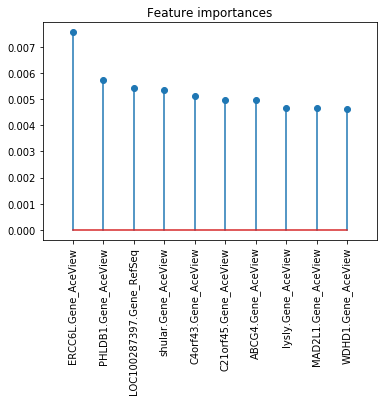

In [63]:
n_feat = 10
plt.figure()
plt.title("Feature importances")
plt.stem(range(n_feat), importances[indices[:n_feat]])
plt.xticks(range(n_feat), genes[indices[:n_feat]], rotation="vertical")
plt.xlim([-1, n_feat])
plt.show()

# 7. Optional topics

## Parameter tuning

As mentioned in the lecture, Scikit learn offers a very useful and flexible tool for parameter tuning called _GridSearchCV_. While the tool is very sophisticated and efficient, it is useful to at least try an example _by hand_ to understand what is happening in the background.

For this example we use a linear SVM and try to tune the C parameter. You might remember from the lectures that the paramenter C essentially controls how much we want to avoid misclassifying each training example. Large values of C result in smaller margins, i.e. closer fitting to the training data. As mentioned in the classes, the drawback is over-fitting, resulting in poor generalization.

In [ ]:
# first of all, let's get a clean train/test split of the original data
x_tr, x_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.2, random_state=78)
# rescale
scaler = preprocessing.StandardScaler()
scaler.fit(x_tr)
x_tr = scaler.transform(x_tr)
x_ts = scaler.transform(x_ts)

In [ ]:
## define the sequence of C values we want to use in the search of the best one
C_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
for C in C_list:
    print('C = ', C)
    svc = SVC(kernel = 'linear', C=C)
    svc.fit(x_tr, y_tr)
    class_pred_ts = svc.predict(x_ts)
    print('MCC = ', metrics.matthews_corrcoef(y_ts, class_pred_ts))
    print('ACC = ', metrics.accuracy_score(y_ts, class_pred_ts))
    print('SENS = ', metrics.recall_score(y_ts, class_pred_ts), "\n")

Depending on the splits I generated with train_test_split, I get the highest MCC for C=1e-5, which I consider the optimal parameter in this setting. You may get different values.

**Optional exercise:** as you already saw in the lectures, there are many parameters that can be tuned, also when considering only one simple classifier. For example, if you consider SVM with 'rbf' kernel, you could check performance changes with different values of C **and** gamma, for example using two nested loops.

In [ ]:
## space for exercise

As we mentioned, Scikit offers fully automated parameter tuning engine. We illustrate its power with a simple example on our data. We use GridSearchCV to search through a grid of C and gamma parameter options for SVM with 'rbf' kernel.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

C_range = [0.001, 0.01, 0.1, 1, 10, 100]
gamma_range = ['auto', 0.01, 1]
# the parameter grid is defined as a dictionary {<parameter>: <values>} for each parameter
param_grid = dict(gamma=gamma_range, C=C_range)
# define the type of cross-validation for the grid search
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42)
# create a GridSearchCV object
grid = GridSearchCV(SVC(kernel="rbf"), param_grid=param_grid, cv=cv, n_jobs=4)
# go!
grid.fit(x_tr, y_tr)

The best parameters and the corresponding average cross-validated score are available in the `best_params_` and `best_score_` attributes, respectively:

In [ ]:
print(grid.best_params_)

In [ ]:
print(grid.best_score_)

_Note: GridSearchCV by default does not maximize the MCC, but the accuracy._

Train a model with the best parameters and predict on the test set, computing a few metrics:

In [ ]:
clf = SVC(kernel="rbf", C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
clf.fit(x_tr, y_tr)
y_pred = clf.predict(x_ts)
print('MCC = ', metrics.matthews_corrcoef(y_ts, y_pred))
print('ACC = ', metrics.accuracy_score(y_ts, y_pred))
print('SENS = ', metrics.recall_score(y_ts, y_pred))